In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from src.github_api import ReplicationCode

# GitHub API

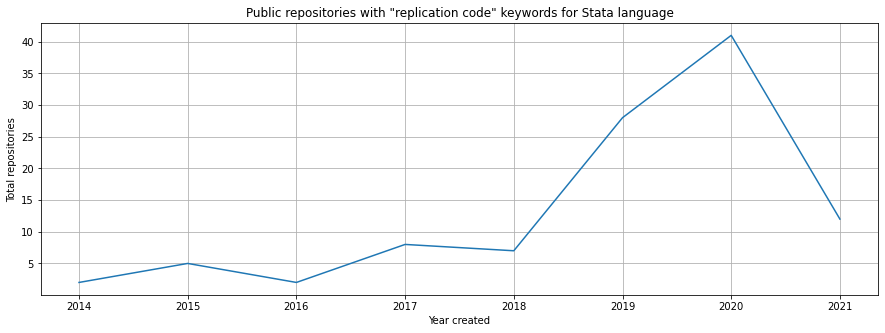

In [2]:
rc = ReplicationCode()
ghapi = rc.dataframe()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('created_at', 'count', data=ghapi)
plt.grid(b=True)
plt.title('Public repositories with "replication code" keywords for Stata language')
plt.xlabel('Year created')
plt.ylabel('Total repositories')
plt.savefig('img/replication-code-stata.png', bbox_inches = 'tight')

# AEA Deposits on ICPSR 

In [3]:
# check whether all data have been downloaded
!python3 src/aea.py --help
!python3 src/aea.py -j aer
!python3 src/aea.py -j aeri
!python3 src/aea.py -j app
!python3 src/aea.py -j pol
!python3 src/aea.py -j mac
!python3 src/aea.py -j mic
!python3 src/aea.py -j jel
!python3 src/aea.py -j jep
!python3 src/aea.py -j pandp

usage: aea.py [-h] [-j]

optional arguments:
  -h, --help       show this help message and exit
  -j , --journal   Journal name: ['aer', 'aeri', 'app', 'pol', 'mac', 'mic',
                   'jel', 'jep', 'pandp']
2021-04-14 22:03:02: https://www.aeaweb.org/journals/aer/issues
2021-04-14 22:03:11: https://www.aeaweb.org/journals/aeri/issues
2021-04-14 22:03:15: https://www.aeaweb.org/journals/app/issues
2021-04-14 22:03:17: https://www.aeaweb.org/journals/pol/issues
2021-04-14 22:03:20: https://www.aeaweb.org/journals/mac/issues
2021-04-14 22:03:23: https://www.aeaweb.org/journals/mic/issues
2021-04-14 22:03:26: https://www.aeaweb.org/journals/jel/issues
2021-04-14 22:03:29: https://www.aeaweb.org/journals/jep/issues
2021-04-14 22:03:32: https://www.aeaweb.org/journals/pandp/issues


In [4]:
aea = os.listdir('data/aea')

In [5]:
def dataframe(file):
    with open(f'data/aea/{file}', 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data['article'])
    df.insert(0, 'issue_url', data['issue_url'])
    df.insert(1, 'publication_date', data['publication_date'])

    return df

In [6]:
df = pd.concat([dataframe(x) for x in aea], sort=False)
df = df.reset_index(drop=True)
df['year'] = df.publication_date.apply(lambda x: x[-4:])
df['year'] = df.year.astype(str)

In [7]:
size = df.groupby('year')['icpsr'].size()
count = df.groupby('year')['icpsr'].count()
icpsr = pd.merge(size, count, on='year')
icpsr['proportion'] = icpsr.icpsr_y / icpsr.icpsr_x
icpsr = icpsr.reset_index()

In [8]:
def monthly():
    # will be used for monthly
    dates = []
    base_date = icpsr.publication_date.min()
    while base_date <= icpsr.publication_date.max():
        if base_date.day == 1:
            dates.append(base_date)
        base_date += timedelta(days=1)
    datesdf = pd.DataFrame(sorted(dates), columns=['publication_date'])

    icpsr = pd.merge(datesdf, icpsr, how='left', on='publication_date')
    icpsr.percent = icpsr.percent.fillna(0)
    
    return icpsr

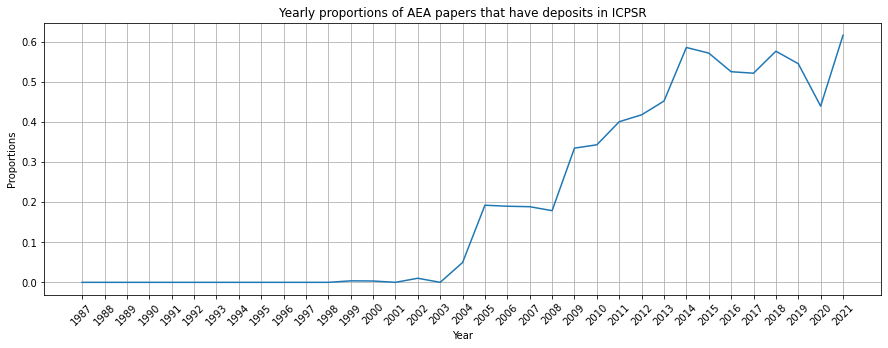

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('year', 'proportion', data=icpsr)
plt.grid(b=True)
plt.title('Yearly proportions of AEA papers that have deposits in ICPSR')
plt.xticks(rotation = 45)
plt.xlabel('Year')
plt.ylabel('Proportions')
plt.savefig('img/aea-deposit-icpsr.png', bbox_inches = 'tight')

# Econometrica 

In [37]:
path = 'data/crossref/s-wly-emetrp'
econometrica = os.listdir(path)
df = []
for e in econometrica[:5]:
    with open(f'{path}/{e}', 'r') as f:
        data = json.load(f)
        url = data['URL']
        status_code = []
        while status_code not in [200, 404]:
            try:
                res = requests.get(url)
                status_code = res.status_code
                content = BeautifulSoup(res.content, features='html.parser')
                article = content.find('article')
                d = {
                    'doi': url,
                    'title': data['title'],
                    'author': data['author'],
                    'publisher': data['publisher'],
                    'created': data['created'],
                    'has_replication': 'replication' in article.text.lower()

                }
                df.append(d)
            except Exception as e:
                print(e)
                pass

In [39]:
pd.DataFrame(df).to_csv('data/econometrica.csv', index=False)